# Figure 2. Clouds and precipitation in the simulations with stretched and quasi-uniform mesh.

[Skip code and jump to the figure](#Show-the-figure)

In [1]:
import warnings

warnings.filterwarnings("ignore")

from dataclasses import dataclass, field
from functools import partial
from pathlib import Path

import cmocean
import geovista as gv
import matplotlib.colors as mcol
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
from aeolus.calc import time_mean
from aeolus.coord import isel
from aeolus.io import load_data
from aeolus.lfric import (
    add_um_height_coord,
    fix_time_coord,
    load_lfric_raw,
    ugrid_spatial,
    ugrid_spatial_mean,
)
from aeolus.model import lfric
from aeolus.plot import capitalise, figsave, subplot_label_generator, tex2cf_units
from aeolus.plot.pv import cube2d_to_mesh
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from tqdm.notebook import tqdm

# PyVista display settings
pv.global_theme.trame.server_proxy_enabled = True
pv.set_jupyter_backend("trame")

Local modules

In [2]:
import paths
from common import SIMULATIONS, SPINUP_DAYS, all_sim_file_label, lfric_precip_sum

In [3]:
# TODO: move to aeolus
from iris.cube import Cube
from iris.experimental.ugrid import MeshCoord
from iris.experimental.ugrid.mesh import Mesh


def replace_mesh(cube: Cube, new_mesh: Mesh) -> Cube:
    """Replace mesh in a 1d cube by creating a new copy of that cube."""
    mesh_x = MeshCoord(mesh=new_mesh, location="face", axis="x")
    mesh_y = MeshCoord(mesh=new_mesh, location="face", axis="y")

    new_cube = Cube(cube.data, aux_coords_and_dims=[(mesh_x, 0), (mesh_y, 0)])
    new_cube.metadata = cube.metadata
    return new_cube

Show all simulations, using instantaneous output

In [4]:
show_sim = [*SIMULATIONS.keys()]
time_prof = "inst_diag"

## Load the data

### First, load the raw instantaneous diagnostics

In [5]:
dset = {}
for sim_label in show_sim:
    dset[sim_label] = {}
    add_levs = partial(
        add_um_height_coord,
        path_to_levels_file=paths.vert / SIMULATIONS[sim_label].vert_lev,
    )

    def _combi_callback(cube, field, filename):
        [
            fix_time_coord(cube, field, filename),
            add_levs(cube, field, filename),
        ]

    fnames = sorted(
        paths.data_raw.glob(
            str(
                Path(SIMULATIONS[sim_label].work_name)
                / "*"
                / "run_lfric_atm_*"
                / f"lfric_{time_prof}.nc"
            )
        ),
        key=lambda x: int(x.parent.parent.name),
    )

    fnames = [
        i
        for i in fnames
        if int(i.parent.parent.name) * SIMULATIONS[sim_label].days_per_job > SPINUP_DAYS
    ]

    dset[sim_label][time_prof] = load_lfric_raw(
        fnames,
        callback=_combi_callback,
        drop_coord=["forecast_reference_time"],
    )

    # Load cell area
    cell_area = load_lfric_raw(
        paths.data_raw
        / SIMULATIONS[sim_label].work_name
        / "1"
        / "run_lfric_atm_*"
        / "lfric_initial.nc",
    ).extract_cube("cell_area")
    # Replace the mesh in the cell area cube to be compatible with main data cubes
    cell_area = replace_mesh(cell_area, dset[sim_label][time_prof][0].mesh)
    dset[sim_label][time_prof].append(cell_area)
    del cell_area

Print file contents

In [6]:
for i, cube in enumerate(dset[show_sim[0]][time_prof]):
    print(f"---|---|-{'-'*30}-|-{'-'*60}")
    print(f"{i:<2d} | {cube.ndim} | {cube.var_name:>30} | {cube.name():>60}")

---|---|--------------------------------|-------------------------------------------------------------
0  | 2 |                    tot_col_m_c |                             atmosphere_mass_content_of_cloud
---|---|--------------------------------|-------------------------------------------------------------
1  | 2 |            cloud_amount_maxrnd |                                          cloud_area_fraction
---|---|--------------------------------|-------------------------------------------------------------
2  | 2 |       grid_surface_temperature |                                     grid_surface_temperature
---|---|--------------------------------|-------------------------------------------------------------
3  | 2 |          low_type_cloud_amount |                                 low_type_cloud_area_fraction
---|---|--------------------------------|-------------------------------------------------------------
4  | 2 |    very_high_type_cloud_amount |               maximum_combined_

### Also load instantaneous data regridded to the uniform mesh (c192p)

In [7]:
tgt_sim_label = "hab1_mod_c192p"
time_prof = "inst_diag"

dset_regr = {}
for sim_label in show_sim:
    dset_regr[sim_label] = load_data(
        paths.data_proc
        / SIMULATIONS[sim_label].work_name
        / f"{SIMULATIONS[sim_label].work_name}_inst_diag_*_regr_to_{tgt_sim_label}.nc".lower()
    )

dset_regr["hab1_mod_c192s10e"].extract_cube("conv_prec").data = np.ma.masked_array(
    dset_regr["hab1_mod_c192s10e"].extract_cube("conv_prec").data.filled(fill_value=0)
)

## Make plots

First, define two functions to create precipitation and cloud fraction histograms - to be combined with another plot down the line.

In [8]:
def plot_precip_hist(cubelist_dict, bin_min, bin_max, bin_step, ax):
    """Make a histogram of total precipitation for LFRic output."""
    bins = np.arange(bin_min, bin_max, bin_step)
    bin_mid = (bins[:-1] + bins[1:]) * 0.5
    yticks = [0.001, 0.01, 0.1, 1, 10, 100]

    extra_label = ""
    if tgt_sim_label:
        extra_label += f"_mesh_{tgt_sim_label}"
    else:
        extra_label += f"_regr_{n_res}"

    axins = inset_axes(ax, width="20%", height="50%", loc="upper right", borderpad=0.75)

    tex_units = "$mm$ $day^{-1}$"

    for i, sim_label in enumerate(show_sim):
        cube = lfric_precip_sum(cubelist_dict[sim_label])
        cube.convert_units(tex2cf_units(tex_units))
        cube_data = cube.data.flatten()
        # print(np.percentile(cube_data, 90))
        tot_pnts = cube_data.size
        label = SIMULATIONS[sim_label].title
        # label = f"{SIMULATIONS[sim_label].title}, {tot_pnts}"
        inc_points = cube_data[cube_data > 1]
        #     inc_points = np.clip(inc_points, bins[0], bins[-1])
        hist, _ = np.histogram(inc_points, bins=bins)
        color = SIMULATIONS[sim_label].kw_plt["color"]
        ax.bar(
            bin_mid,
            hist / tot_pnts * 100,
            label=label,
            alpha=0.9,
            width=(0.9 - i * 0.2) * bin_step,
            color=[color],
        )
        # Number of non-precip points in an inset axis
        non_precip_size = cube_data[cube_data <= 1].size
        axins.bar(
            i, non_precip_size / tot_pnts * 100, alpha=0.9, width=0.8, color=[color]
        )

    # axins.set_ylabel("[% of grid points]")
    axins.set_xticks([])
    axins.set_xlabel(rf"Weak or \nNo Precipitation\n($\leq$ 1 {tex_units})")
    # axins.set_yticks(yticks)
    axins.set_ylim(90, 100)
    axins.yaxis.set_major_formatter("{x:.0f} %")

    leg = ax.legend(loc="upper center", fontsize="large", frameon=False)
    # leg.set_title("Simulation, Points in total")

    ax.grid(visible=False, axis="x")
    # ax.set_ylabel(f'[% of precipitating grid points ($\gt$ 1 {unit_str})]')
    # ax.set_ylabel("[% of grid points]", size="x-large")
    ax.set_ylim(yticks[0], yticks[-1])
    ax.set_yscale("log")
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)
    ax.yaxis.set_major_formatter("{x} %")
    ax.set_xlim(bins[0], bins[-1])
    # ax.set_xticks(np.concatenate([[bins[0]], bins[19::20]]))
    ax.set_xlabel(f"[{tex_units}]", size="x-large")
    ax.set_title(
        "Percentage of Grid Points with Different Precipitation",
        loc="right",
        fontdict={"weight": "bold"},
        pad=3,
    )
    if tgt_sim_label:
        if SIMULATIONS[tgt_sim_label].stretch_factor > 1:
            at_txt = "Regridded to a common\nstretched mesh"
        else:
            at_txt = "Regridded to a common\nuniform mesh"
    else:
        at_txt = f"Regridded to a common\nlat-lon n{n_res} grid"
    ax.add_artist(
        AnchoredText(
            at_txt,
            loc="lower right",
            prop=dict(size="small", ha="right"),
            frameon=False,
        )
    )

In [9]:
def plot_caf_bar(data_dict, show_sim, cloud_types, ax, width=0.2, add_legend=True):
    """Make a bar chart of cloud fraction by cloud types, like Fig. 6 in Kajikawa+ (2016)."""
    x = np.arange(len(cloud_types))  # the label locations

    axins = inset_axes(ax, width="40%", height="30%", loc="upper right")

    for isim, sim_label in enumerate(show_sim):
        rects = ax.bar(
            x + width * isim,
            [data_dict[sim_label][cloud_type] for cloud_type in cloud_types],
            width,
            label=SIMULATIONS[sim_label].title,
            color=SIMULATIONS[sim_label].kw_plt["color"],
        )
        ax.bar_label(
            rects,
            fmt="%.0f",
            padding=0,
            weight="bold",
            size="large",
            color=SIMULATIONS[sim_label].kw_plt["color"],
        )

        rects = axins.bar(
            width * isim,
            [data_dict[sim_label][lfric.caf]],
            width,
            label=SIMULATIONS[sim_label].title,
            color=SIMULATIONS[sim_label].kw_plt["color"],
        )
        axins.bar_label(
            rects,
            fmt="%.0f",
            padding=0,
            weight="bold",
            size="large",
            color=SIMULATIONS[sim_label].kw_plt["color"],
        )
    if add_legend:
        ax.legend(frameon=False, loc="upper center", fontsize="large")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    # ax.set_ylabel("Area fraction")
    ax.set_title(
        "Cloud Area Fraction [%] Grouped by Height",
        loc="right",
        fontdict={"weight": "bold"},
        pad=3,
    )
    # ax.set_xlim(-width, width * (len(show_sim)+2))
    ax.set_xticks(x + width * 1.5, [capitalise(s) for s in cloud_types])
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.set_yticks([])

    axins.set_ylim(0, 50)
    axins.set_xlim(-width, width * len(show_sim))
    axins.set_xticks([width * 1.5], ["Total"])
    axins.spines.right.set_visible(False)
    axins.spines.top.set_visible(False)
    axins.spines.bottom.set_visible(False)
    axins.spines.left.set_visible(False)
    axins.set_yticks([])

    # ax.spines.left.set_bounds(0, 0.8)
    ax.tick_params(axis="x", which="both", length=0, pad=3, labelsize="large")
    axins.tick_params(axis="x", which="both", length=0, pad=3, labelsize="large")
    # ax.grid(visible=True, axis="y")


# savefig = False
# fig, ax = plt.subplots(layout="constrained")
# plot_caf_bar(cloud_fracs, show_sim, cloud_types, ax, width=0.2)


# if savefig:
#     figsave(
#         fig,
#         paths.figures
#         / "drafts"
#         / f"gd_mean__{'_'.join(show_sim)}__{time_prof}__cloud_types",
#     )

### GeoVista Maps

Define diagnostics for geovista plots.

In [10]:
# Precipitation rate levels and colormap
n_prec_lev = 8
prec_clim = [1, 100]
prec_levels = np.linspace(prec_clim[0], prec_clim[-1], n_prec_lev + 1)
prec_colors = cmocean.cm.rain(np.linspace(0, 1, n_prec_lev))
prec_cmap, prec_norm = mcol.from_levels_and_colors(prec_levels, prec_colors)

In [11]:
@dataclass
class Diag:
    recipe: callable
    title: str
    units: str
    kw_plt: dict = field(default_factory=dict)


DIAGS = {
    "t_sfc": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.t_sfc),
        title="Surface Temperature",
        units="K",
        kw_plt=dict(cmap=cmocean.cm.thermal),
    ),
    "toa_olr": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.toa_olr),
        title="TOA OLR",
        units="$W$ $m^{-2}$",
        kw_plt=dict(cmap=cmocean.cm.gray_r),
    ),
    "toa_osr": Diag(
        recipe=lambda cl: cl.extract_cube(lfric.toa_osr),
        title="TOA OSR",
        units="$W$ $m^{-2}$",
        kw_plt=dict(cmap=cmocean.cm.gray, clim=[50, 400]),
    ),
    "mid_in_col": Diag(
        recipe=lambda cl: cl.extract_cube("mid_in_col"),
        title="Frequency of midlevel convection",
        units="%",
        kw_plt=dict(cmap=cmocean.tools.crop_by_percent(cmocean.cm.oxy, 20, "min")),
    ),
    "shallow_in_col": Diag(
        recipe=lambda cl: cl.extract_cube("shallow_in_col"),
        title="Frequency of shallow convection",
        units="%",
        kw_plt=dict(cmap=cmocean.tools.crop_by_percent(cmocean.cm.oxy, 20, "min")),
    ),
    "tot_prec": Diag(
        recipe=lambda cl: lfric_precip_sum(cl),
        title="Total\nPrecipitation\n",
        units="$mm$ $day^{-1}$",
        kw_plt=dict(cmap=prec_cmap, clim=prec_clim),
    ),
    "tot_col_m_c": Diag(
        recipe=lambda cl: cl.extract_cube("tot_col_m_c"),
        title="Total Column\nCloud Water",
        units="$kg$ $m^{-2}$",
        kw_plt=dict(cmap=cmocean.cm.gray, clim=[0, 1]),
        # log_scale=True,
        # clim=[1e-3, 1e0],
    ),
}

Select what variables to plot

In [12]:
diag_keys = ["tot_col_m_c", "tot_prec"]
t_idx = -1  # Last time snapshot
reduce_func = lambda cube: isel(cube, lfric.t, t_idx)

gv_meshes = {}
stats = {}
for sim_label in show_sim:
    gv_meshes[sim_label] = {}
    # stats[sim_label] = {}
    for diag_key in diag_keys:
        cube2d = reduce_func(DIAGS[diag_key].recipe(dset[sim_label][time_prof]))
        cube2d.convert_units(tex2cf_units(DIAGS[diag_key].units))
        gv_meshes[sim_label][diag_key] = cube2d_to_mesh(cube2d)
        if diag_key == "tot_prec":
            gv_meshes[sim_label][diag_key] = (
                gv_meshes[sim_label][diag_key]
                .cell_data_to_point_data()
                .contour_banded(n_prec_lev, generate_contour_edges=False)
            )
        #     gv_meshes[sim_label][diag_key] = gv_meshes[sim_label][diag_key].threshold(
        #         DIAGS[diag_key].kw_plt["clim"][0]
        #     )
        # stats[sim_label][diag_key] = {}
        # stats[sim_label][diag_key]["mean"] = float(
        #     ugrid_spatial_mean(
        #         DIAGS[diag_key].recipe(dset[sim_label][time_prof]),
        #         weights=dset[sim_label][time_prof].extract_cube("cell_area").data,
        #     ).data
        # )

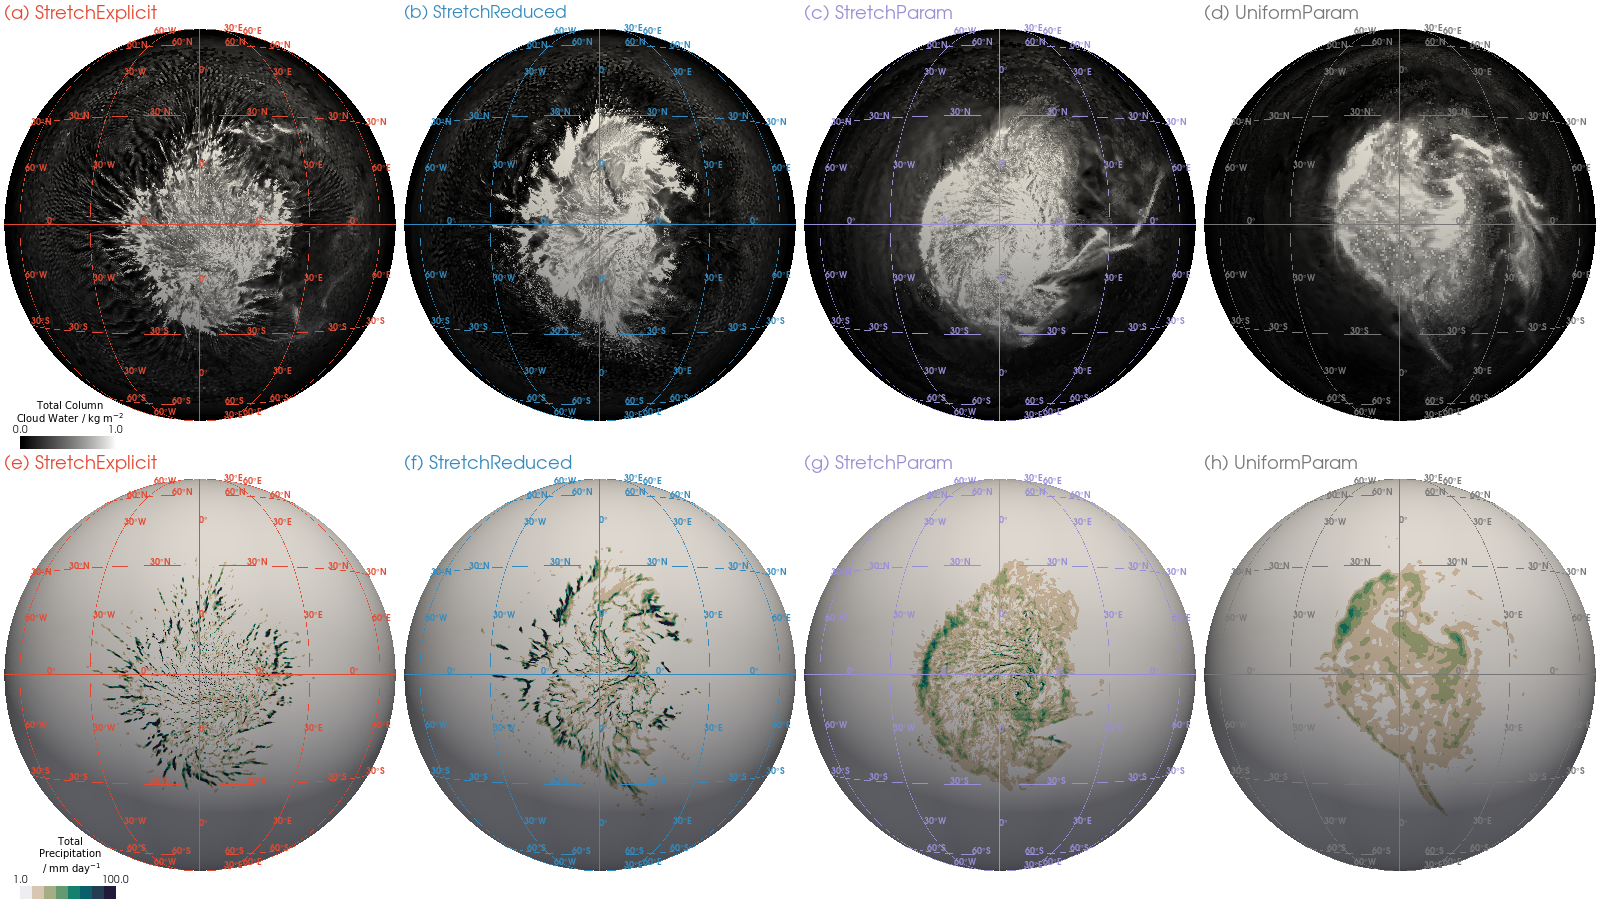

In [13]:
savefig = True
tilted = False
add_grat = True

plotter = gv.GeoPlotter(
    window_size=[400 * len(show_sim), 450 * len(diag_keys)],
    shape=(len(diag_keys), len(show_sim)),
    border=False,
)
zoom = 1.7
kw_grat = dict(
    lon_step=30,
    lat_step=30,
    mesh_args={"color": "grey"},
    point_labels_args={"shape_opacity": 0, "text_color": "grey", "shadow": False},
)
letters = subplot_label_generator()

for diag_idx, diag_key in enumerate(diag_keys):
    scalar_bar_args = {
        # "title": f"{SIMULATIONS[sim_label].title}\n{DIAGS[diag_key].title} / {DIAGS[diag_key].units}",
        "title": f"{DIAGS[diag_key].title} / {DIAGS[diag_key].units}",
        "color": "k",
        "title_font_size": 10,
        "label_font_size": 10,
        "shadow": False,
        "n_labels": 2,
        "italic": False,
        "bold": False,
        "fmt": "%.1f",
        "font_family": "arial",
        "width": 0.25,
        "vertical": False,
        "position_x": 0.05,  # 0.225
        "position_y": 0.0,  # 0.9
    }
    for sim_idx, sim_label in enumerate(show_sim):
        color = SIMULATIONS[sim_label].kw_plt["color"]
        plotter.subplot(diag_idx, sim_idx)
        plotter.add_text(
            f"({next(letters)}) {SIMULATIONS[sim_label].title}",
            position="upper_left",
            font_size=10,
            color=color,
        )
        plotter.add_mesh(
            gv_meshes[sim_label][diag_key],
            show_scalar_bar=True,  # (sim_idx == diag_idx),
            zlevel=0,
            scalar_bar_args=scalar_bar_args,
            **DIAGS[diag_key].kw_plt,
            # annotations={10**e: f"$10^{{{e}}}$" for e in range(-4, 2)},
            # annotations={
            #     stats[sim_label][diag_key][
            #         "mean"
            #     ]: f"Mean: {stats[sim_label][diag_key]['mean']:.1f}",
            # },
        )
        kw_grat["point_labels_args"]["text_color"] = color
        kw_grat["mesh_args"]["color"] = color
        if add_grat:
            plotter.add_graticule(**kw_grat)
            extra_label = "__grat"
        else:
            extra_label = ""
        if tilted:
            plotter.camera.position = (6.5, 2.5, 2.5)
            extra_label += "_tilt_view"
        else:
            plotter.view_yz(negative=False)
        plotter.camera.zoom(zoom)

plotter.show(jupyter_backend="static")

if savefig:
    imgname = (
        paths.figures
        / "drafts"
        / f"nat_mesh__{all_sim_file_label(show_sim)}__{time_prof}__{'_'.join(diag_keys)}{extra_label}.png"
    )
    plotter.screenshot(imgname)
    plotter.close()

### Combine the snapshots with the histograms

Read the geovista image back

In [14]:
gv_image = plt.imread(imgname)

Prepare data for the cloud fraction bar char

In [15]:
collapse_spatially = lambda cube: cube
# .extract(DAYSIDE.constraint)

cloud_types = ["very_low", "low", "medium", "high", "very_high"]

# calculate the metrics first
cloud_fracs = {}
for sim_label in tqdm(show_sim):
    cloud_fracs[sim_label] = {}
    for cloud_type in tqdm(cloud_types):
        cloud_fracs[sim_label][cloud_type] = time_mean(
            ugrid_spatial(
                collapse_spatially(
                    dset[sim_label][time_prof].extract_cube(
                        f"{cloud_type}_type_cloud_amount"
                    )
                ),
                "mean",
                model=lfric,
                weights=collapse_spatially(
                    dset[sim_label][time_prof].extract_cube("cell_area")
                ).lazy_data(),
            )
        )
        cloud_fracs[sim_label][cloud_type].convert_units("1")
        cloud_fracs[sim_label][cloud_type].convert_units("%")
        cloud_fracs[sim_label][cloud_type] = float(
            cloud_fracs[sim_label][cloud_type].data
        )
    # Add total cloud area fraction
    cloud_fracs[sim_label][lfric.caf] = time_mean(
        ugrid_spatial(
            collapse_spatially(dset[sim_label][time_prof].extract_cube(lfric.caf)),
            "mean",
            model=lfric,
            weights=collapse_spatially(
                dset[sim_label][time_prof].extract_cube("cell_area")
            ).lazy_data(),
        )
    )
    cloud_fracs[sim_label][lfric.caf].convert_units("1")
    cloud_fracs[sim_label][lfric.caf].convert_units("%")
    cloud_fracs[sim_label][lfric.caf] = float(cloud_fracs[sim_label][lfric.caf].data)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Construct a multi-panel plot for the final figure.

In [16]:
fig = plt.figure(figsize=(8, 7), layout="constrained")
axd = fig.subplot_mosaic(
    [["gv_image"] * 2, ["prec_hist", "caf_hist"]], height_ratios=[3 / 4, 1 / 4]
)

axd["gv_image"].imshow(gv_image)
axd["gv_image"].axis("off")


axd["prec_hist"].set_title(
    f"(i)",  # {next(iletters)}
    loc="left",
    fontdict={"weight": "bold"},
    pad=3,
)
plot_precip_hist(dset_regr, 1, 201, 5, axd["prec_hist"])
axd["caf_hist"].set_title(
    f"(j)",  # {next(iletters)}
    loc="left",
    fontdict={"weight": "bold"},
    pad=3,
)
plot_caf_bar(
    cloud_fracs, show_sim, cloud_types, axd["caf_hist"], width=0.2, add_legend=False
)

plt.close()

# Show the figure

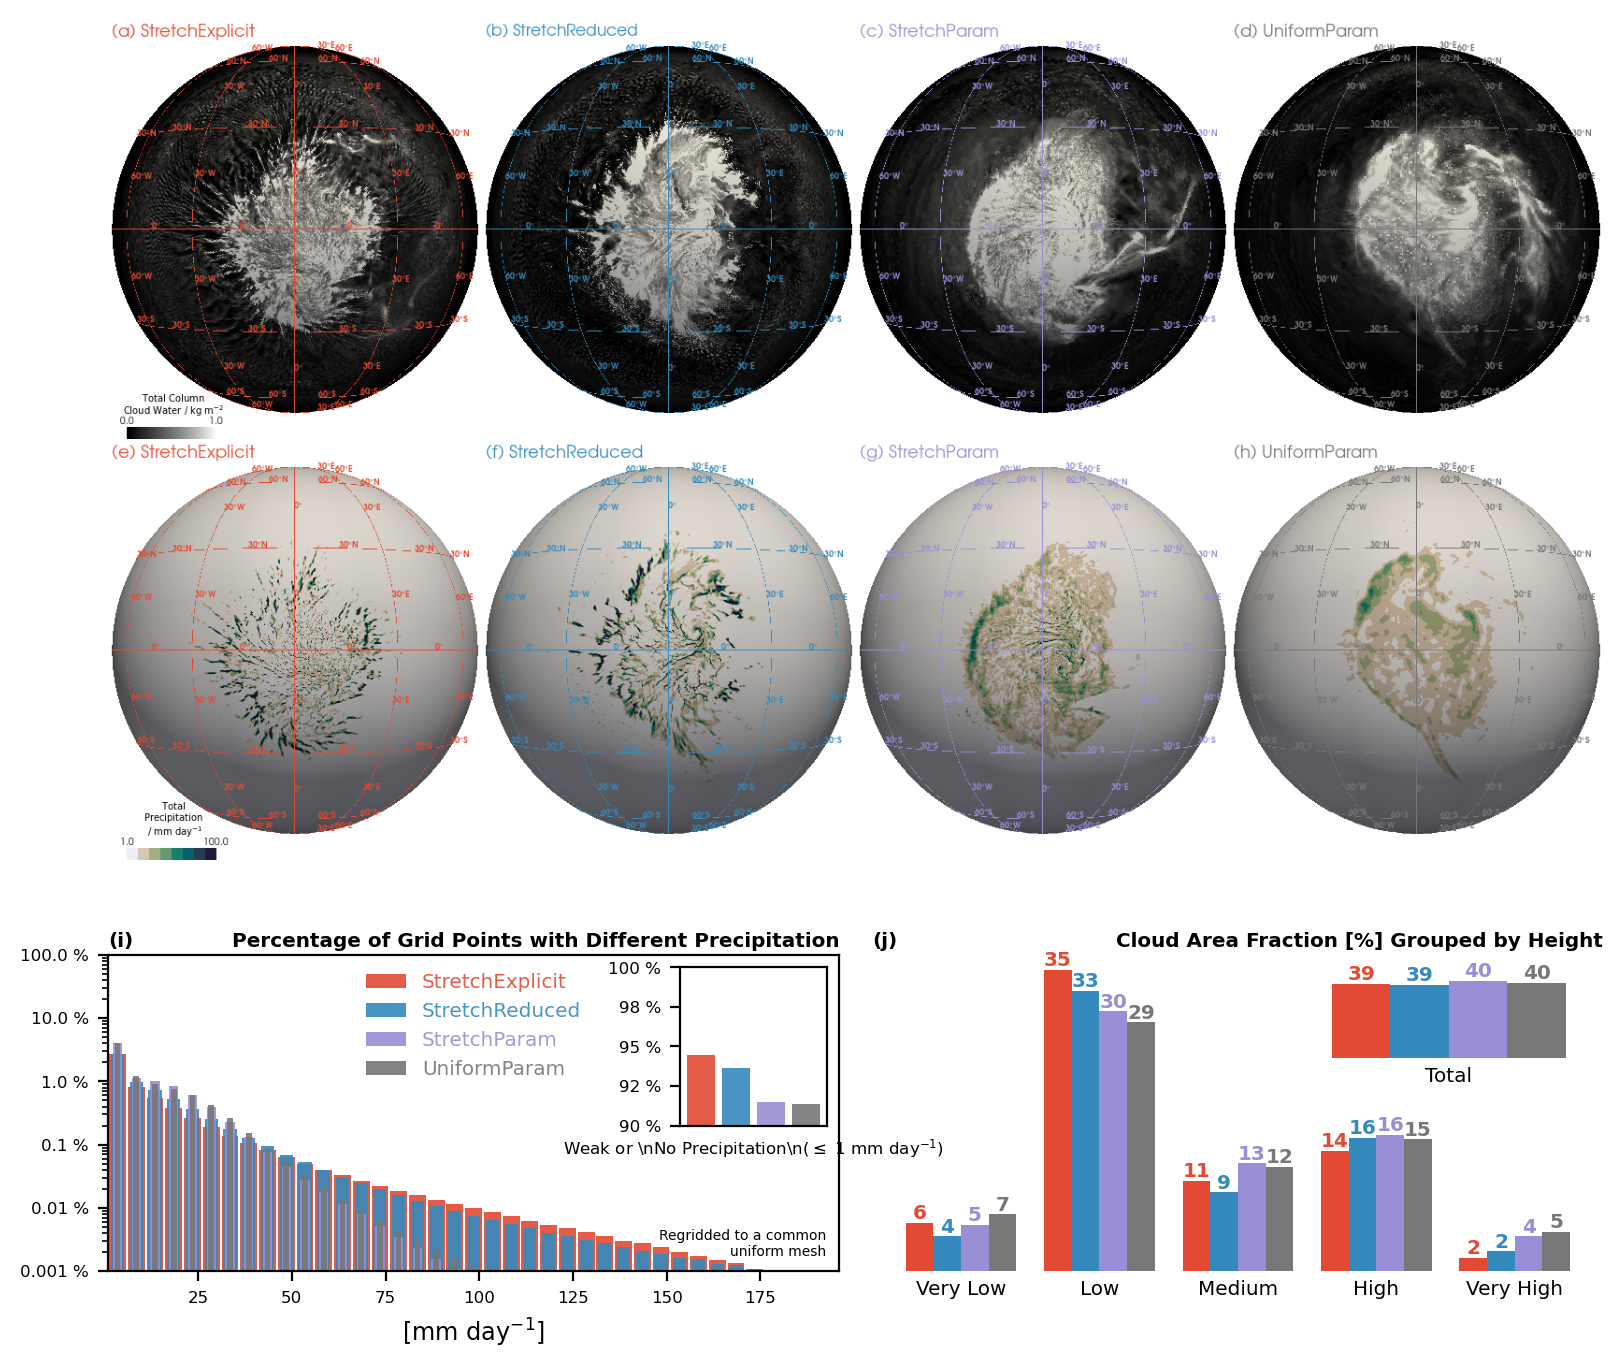

In [17]:
fig

- **(a--d) Maps of instantaneous vertically integrated cloud water (liquid plus ice) at the end of the simulations ($kg$ $m^{-2}$).**
- **(e--h) Maps of instantaneous precipitation rate ($mm$ $day^{-1}$).**
- **The substellar point is at the center of the maps (0$^\circ$N, 0$^\circ$E).**
- **(i) Histogram of instantaneous precipitation rate interpolated to a common quasi-uniform mesh (same mesh as in the _UniformParam_ simulation).**
- **The histogram shows the percentage of grid cells with precipitation above 1 $mm$ $day^{-1}$, binned with a step of 5 $mm$ $day^{-1}$.**
- **Note the logarithmic scale of the vertical axis.**
- **The inset shows the percentage of grid cells with precipitation below 1 $mm$ $day^{-1}$ (weak or non-precipitating points).**
- **(j) Bar chart of cloud area fraction (%) grouped by different heights.**

In [18]:
# and save it
figsave(
    fig,
    paths.figures
    / f"combi_{all_sim_file_label(show_sim)}__{time_prof}__{'_'.join(diag_keys)}{extra_label}__precip_sum_hist__cloud_types",
)